## Download data

In [2]:
!git clone "https://github.com/xhxuciedu/CS284A.git"

fatal: destination path 'CS284A' already exists and is not an empty directory.


In [3]:
BASE_DIR = "/content/CS284A/wbc-classification/"

# Classifying White Blood Cells

### Introduction

An important problem in blood diagnostics is classifying different types of blood cells. In this notebook, we will attempt to train a classifier to predict the type of a blood cell given a dyed picture of it.

### Data

We have 352 pictures of dyed white blood cells along with labels of what type of blood cell they are. Below is an example of each of the types of blood cells in our dataset.

##### Basophil
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Basophil.jpg?raw=1" width=400>

#### Eosinophil
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Eosinophil.jpg?raw=1" width=400>

#### Lymphocyte
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Lymphocyte.jpg?raw=1" width=400>

#### Monocyte
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Monocyte.jpg?raw=1" width=400>

#### Neutrophil
<img src="https://github.com/xhxuciedu/CS284A/blob/master/wbc-classification/notebooks/Neutrophil.jpg?raw=1" width=400>

### Methodology

We use a simple LeNet architecture trained on 281 training samples with image augmentation. Our augmentation techniques include rotations, shifts, and zooms.

We validate our results against 71 samples.


# Code

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import scipy
import os




In [5]:
epochs = 20
#BASE_DIR = '../'
batch_size = 32

In [6]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [7]:
model = get_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 158, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 32)        0

## get data 

In [8]:
from skimage.transform import resize

In [9]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in os.listdir(folder + wbc_type):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    #img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_file = resize(img_file, (120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [10]:
# read data
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()  # convert labels to 0 to n-1
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [11]:
y_train.shape, X_train.shape

((9957,), (9957, 120, 160, 3))

## pytorch model

In [12]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

### Check GPU availability

In [13]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Hyper parameters

In [14]:
# Hyper parameters
num_classes = 2
batch_size = 32

### train and test dataloader
* transpose input numpy.  input shape: 120x160x3 -> 3x120x160
* Create dataset (torch.tensor type)
* Create dataloder

In [15]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [16]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train.transpose(0,3,1,2)/255.).float(), torch.from_numpy(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test.transpose(0,3,1,2)/255.).float(), torch.from_numpy(y_test))

In [17]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,                                           
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### Check dataloader

In [18]:
images, labels = next(iter(train_loader))

In [19]:
print(images.shape, labels.shape)

torch.Size([32, 3, 120, 160]) torch.Size([32])


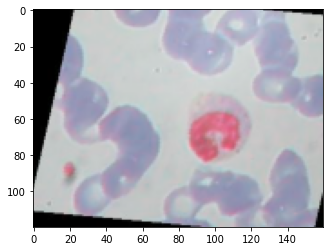

In [20]:
plt.imshow(255*images[2,:,:,:].cpu().permute(1,2,0))

### Model

In [21]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.dense = nn.Sequential(nn.Linear(15*20*64, 64),
                                 nn.ReLU())
        #self.fc = nn.Linear(64, 1)
        self.fc = nn.Linear(15*20*64, 1)
        
    def forward(self, x):
        out = self.layer1(x)  # 3x120x160 -> 16x60x80
        out = self.layer2(out) # 16x60x80 -> 32x30x40
        out = self.layer3(out) # 32x30x40 -> 32x15x20
        out = out.reshape(out.size(0), -1)
        #out = self.dense(out)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

In [22]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=19200, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc): Linear(in_features=19200, out_features=1, bias=True)
)


### test the model; run the model

In [23]:
tmp = model(images.to(device))

In [24]:
tmp.shape, images.shape

(torch.Size([32, 1]), torch.Size([32, 3, 120, 160]))

In [25]:
tmp

tensor([[0.0123],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0123],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0123],
        [0.0122],
        [0.0122],
        [0.0123],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0123],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0122],
        [0.0123],
        [0.0122]], device='cuda:0', grad_fn=<AddmmBackward>)

### training

In [27]:
learning_rate = 0.001
num_epochs = 5

In [33]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [34]:
# Train the model
#model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/312], Loss: 0.6928
Epoch [1/5], Step [200/312], Loss: 0.6934
Epoch [1/5], Step [300/312], Loss: 0.6927
Epoch [2/5], Step [100/312], Loss: 0.6924
Epoch [2/5], Step [200/312], Loss: 0.6932
Epoch [2/5], Step [300/312], Loss: 0.6929
Epoch [3/5], Step [100/312], Loss: 0.6939
Epoch [3/5], Step [200/312], Loss: 0.6945
Epoch [3/5], Step [300/312], Loss: 0.6931
Epoch [4/5], Step [100/312], Loss: 0.6944
Epoch [4/5], Step [200/312], Loss: 0.6927
Epoch [4/5], Step [300/312], Loss: 0.6931
Epoch [5/5], Step [100/312], Loss: 0.6929
Epoch [5/5], Step [200/312], Loss: 0.6937
Epoch [5/5], Step [300/312], Loss: 0.6931


In [84]:
labels

tensor([1, 1, 0, 0, 0], device='cuda:0')

In [100]:
# Training accuracy
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} train images: {:.3f} %'.format(total,100 * correct / total))

Test Accuracy of the model on the 9957 train images: 49.824 %


### Testing

In [71]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {:.3f} %'.format(total,100 * correct / total))

Test Accuracy of the model on the 71 test images: 14.085 %


In [53]:
X_train.shape, X_test.shape

((9957, 120, 160, 3), (71, 120, 160, 3))

In [55]:
predicted

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

# Accuracy

In [61]:
y_pred = predicted.cpu().numpy()

In [62]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
print(accuracy_score(y_test, y_pred))

Predicting on test data
0.8591549295774648


# Confusion Matrix

In [63]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[ 0 10]
 [ 0 61]]


# Images Misclassified

In [ ]:
false_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 0))

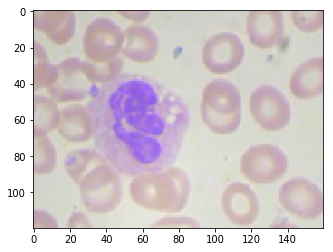

In [ ]:
img = X_test[false_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Mononuclear Cells Classified Correctly

In [ ]:
true_positive_mononuclear = np.intersect1d(np.where(y_pred == 1), np.where(y_test == 1))

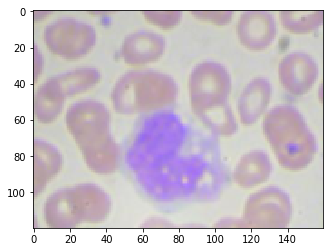

In [ ]:
img = X_test[true_positive_mononuclear[0]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

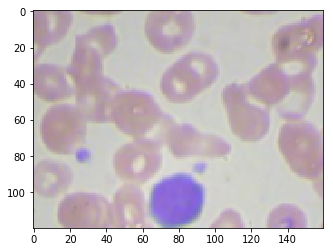

In [ ]:
img = X_test[true_positive_mononuclear[5]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

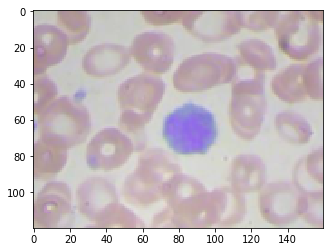

In [ ]:
img = X_test[true_positive_mononuclear[8]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Polynuclear Cells Classified Correctly

In [ ]:
true_positive_polynuclear = np.intersect1d(np.where(y_pred == 0), np.where(y_test == 0))

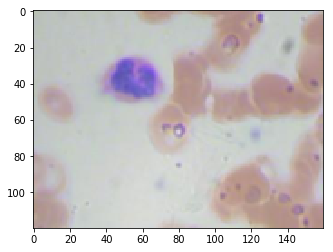

In [ ]:
img = X_test[true_positive_polynuclear[21]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

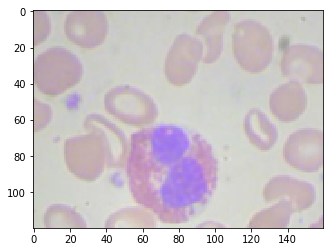

In [ ]:
img = X_test[true_positive_polynuclear[53]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

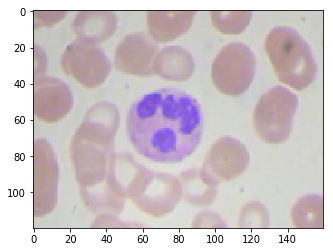

In [ ]:
img = X_test[true_positive_polynuclear[16]]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Keras model

In [26]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./255., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [27]:
model = get_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 118, 158, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 118, 158, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 59, 79, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 77, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 57, 77, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 38, 32)       

In [ ]:
model = get_model()

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

Epoch 1/20
